In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def ss_simulate_1D(f, a, h, q, r, T):

    x = np.zeros(T) # state variable
    y = np.zeros(T) # observation variable

    x0 = 0.0    # initial condition for state variable

    for t in range(T):
        v = rng.standard_normal(1) * np.sqrt(q) # innovation for x
        w = rng.standard_normal(1) * np.sqrt(r) # innovation for y

        x[t] = f * x0 + v # state equation
        y[t] = a + h * x[t] + w # observation equation

        x0 = x[t] # next starting point
    
    return x, y

def KF_1D(y: np.ndarray, f, a, h, q, r):

    # start (x_{t|t-1}, state variable prediction)
    x0_pred = 0.0
    p0_pred = q / (1.0 - f**2)

    x_upd =  np.zeros(y.shape)
    p_upd = np.zeros(y.shape)

    x_pred =  np.zeros(T)
    p_pred = np.zeros(T)
    
    for t, y_t in enumerate(y):
        x_pred[t] = x0_pred
        p_pred[t] = p0_pred

        # correction
        K = p0_pred * h / (h * p0_pred * h + r) # Kalman gain (Hamilton has 'f' term included. But, others tend not to include f. )
        x_upd[t] = x0_pred + K * (y_t - a - h * x0_pred) # mean update
        p_upd[t] = p0_pred - K * h * p0_pred # variance update

        # predict
        x0_pred = f * x_upd[t] # predict mean
        p0_pred = f * p_upd[t] * f + q

    return x_upd, p_upd, x_pred, p_pred



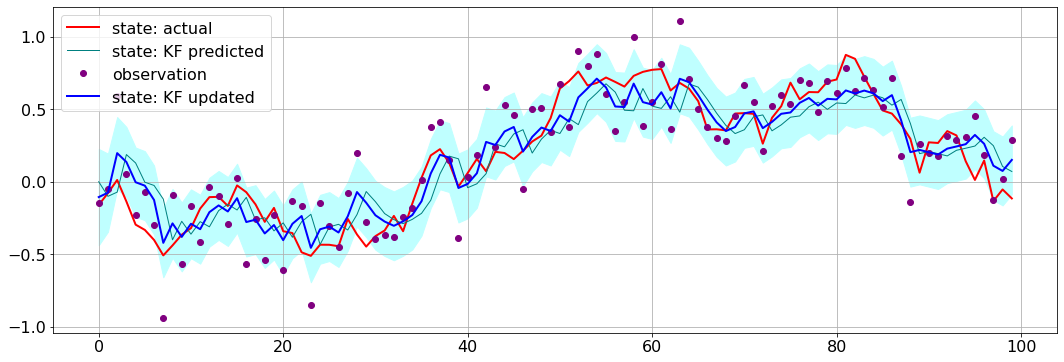

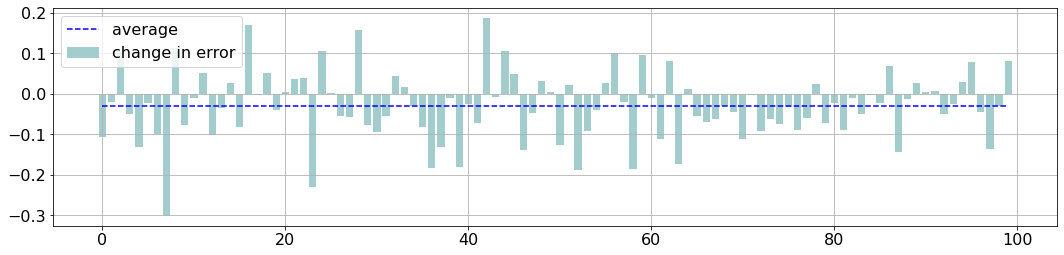

In [71]:
f = 0.95
a = 0.0
h = 1.0 
q = 0.1**2 # state-variable randomness
r = 0.2**2 # errors in observations
T = 100

rng = np.random.default_rng(1234)

x, y = ss_simulate_1D(f, a, h, q, r, T)
t = np.arange(T)

x_upd, p_upd, x_pred, p_pred = KF_1D(y, f, a,  h, q, r)
s_upd = np.sqrt(p_upd)

def l2_norm(v):
    return np.sqrt(np.sum(v**2))

w = scipy.stats.norm.ppf(0.975)

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(18,6))
plt.fill_between(t, x_upd + w * s_upd, x_upd - w * s_upd, color=np.array([0.75,1,1]))
plt.plot(t, x, 'r', lw=2, label='state: actual')
plt.plot(t, x_pred, c='teal', lw = 1, label='state: KF predicted')
plt.plot(t, y, 'o', c = 'purple', label='observation')
plt.plot(t, x_upd, 'b', lw = 2, label='state: KF updated')
plt.legend(loc=2)
plt.grid()
plt.show()

plt.figure(figsize=(18,4))
err_change = np.abs(x_upd -x) - np.abs(x_pred - x)
plt.bar(t, err_change, color=0.8*np.array([0.8,1,1]), label='change in error')
plt.plot(t, np.ones_like(t) * np.mean(err_change), '--', color='b', label='average')
plt.legend(loc=2)
plt.grid()
plt.show()

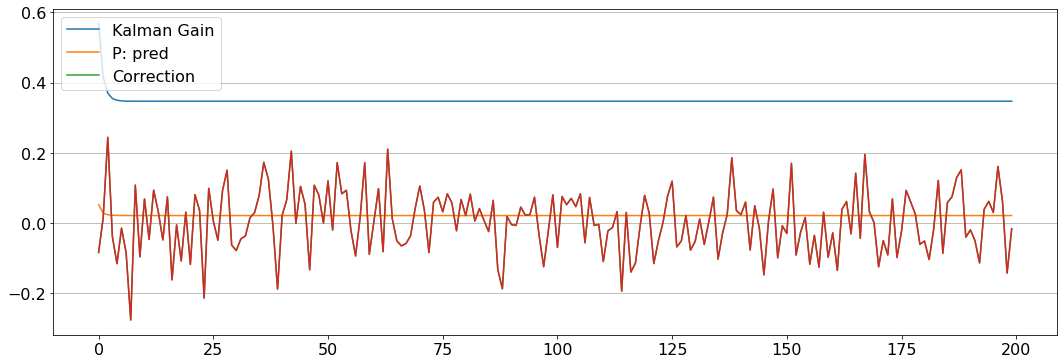

In [5]:
pred_y_err = y - a - h * x_pred
Kt = p_pred*h/(h*p_pred*h + r)
crctn = Kt * pred_y_err
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(18,6))
#plt.plot(t, pred_y_err, label='y-error, predicted')
plt.plot(t, Kt, label='Kalman Gain')
plt.plot(t, p_pred, label='P: pred')
plt.plot(t, crctn, label='Correction')
plt.plot(t, x_upd - x_pred)
plt.legend(loc=2)
plt.grid(axis='y')
plt.show()

In [9]:
plt.close('all')

# Tracking the constant velocity aircraft in one-dimention
Following the tutorial here:
https://www.kalmanfilter.net/alphabeta.html

In [63]:
# state extrapolation = transition = prediction equation
def predict_eq(x, v, dt, a = 0.0):
    x_pred = x + dt*v + 0.5*a*dt**2
    v_pred = v + a*dt
    return x_pred, v_pred

# state update equation
def update_eq(x, v, z, dt, alpha, beta):
    x_new = x + alpha*(z-x)
    v_new = v + beta*(z-x)/dt
    return x_new, v_new

In [70]:
# time steps
dt = 5.0
# true values (hidden)
v_tv = 40 # m/s
x0_tv = 30000 #m
a_tv = 0.0 # for non-zero, the following alpha-beta filter does not work. Need a third factor. 


# measurement noise (sigma
sig_z = 100
alpha = 0.2
beta = 0.1

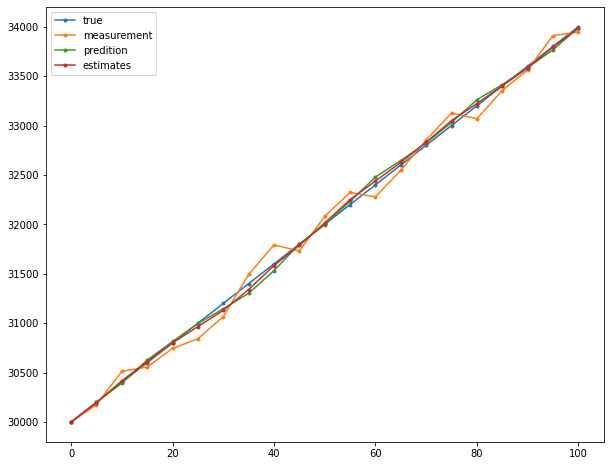

In [69]:
# Initialisation
# note: the tutorial assumes the true values as the initial conditions
x0 = 30000
v0 = 40

# Iteration
x_tv_t = [x0_tv] # true value
v_tv_t = [v_tv]
x_pred_t = [x0]  # predition of the distance
v_pred_v = [v0] # prediction of the speed
x_es_t = [x0] # estimates of the distance
v_es_t = [v0] # estimates of the speed
z_t = [x0] # measurement
time_t = [0] # time

N = 20 # number of stepa
for n in range(N):
    
    ### true values to keep
    x_tv_new, v_tv_new = predict_eq(x_tv_t[n], v_tv_t[n], dt, a_tv)
    x_tv_t.append(x_tv_new)
    v_tv_t.append(v_tv_new)

    ### Kalman Filter
    # 1) predicted values
    x_pred_new, v_pred_new = predict_eq(x_es_t[n], v_es_t[n], dt)
    x_pred_t.append(x_pred_new)
    v_pred_v.append(v_pred_new)
    # 2) measurement of distance - add noise to the true value as a way to simulate
    z_new = x_tv_new + np.random.normal(0.0, sig_z)
    z_t.append(z_new)
    # 3) update
    x_es_new, v_es_new = update_eq(x_pred_new, v_pred_new, z_new, dt, alpha, beta)
    x_es_t.append(x_es_new)
    v_es_t.append(v_es_new)

    # time
    time_t.append(time_t[n]+dt)

plt.figure(figsize=(10,8))
plt.plot(time_t, x_tv_t, '.-', label='true')
plt.plot(time_t, z_t, '.-', label='measurement')
plt.plot(time_t, x_pred_t, '.-', label='predition')
plt.plot(time_t, x_es_t, '.-', label='estimates')
plt.legend()
plt.show()